## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
from textblob import TextBlob
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import re
import string
import glob
import emoji
import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [ ]:

# get karachi tweets
karachi = pd.read_csv('../input/tweets/Karachi_travel_tweets.csv')
karachi1 = pd.read_csv('../input/tweets/Karachi_visit_tweets.csv')

# concatenate karachi tweets
karachi_df = pd.concat([karachi, karachi1], ignore_index=True)
karachi_df['city'] = 'karachi'

# get lahore tweets
lahore = pd.read_csv('../input/tweets/visit_lahore_tweets converted.csv')
lahore1 = pd.read_csv('../input/tweets/travel_lahore_tweets converted.csv')

# concatenate lahore tweets
lahore_df = pd.concat([lahore, lahore1], ignore_index=True)
lahore_df['city'] = 'lahore'

# get gilgit tweets
gilgit = pd.read_csv('../input/tweets/Gilgit_tweets.csv')
gilgit['city'] = 'gilgit'

# get neelum valley tweets
neelum_valley = pd.read_csv('../input/tweets/NeelumValley_tweets.csv')
neelum_valley['city'] = 'neelum_valley'

# get northern tweets
northern = pd.read_csv('../input/tweets/Pakistan_north_tweets.csv')
northern1 = pd.read_csv('../input/tweets/Pakistan_northern_tweets.csv')

# concatenate northern tweets
northern_df = pd.concat([northern, northern1], ignore_index=True)
northern_df['city'] = 'northern area'

# # Concatenate all data into one DataFrame
df = pd.concat([karachi_df, lahore_df, gilgit, neelum_valley, northern_df], ignore_index=True)
df.head()

,text,hashtags,city,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,karachi,NaN,NaN,NaN
1,This photo captured on the beach of karachi pa...,NaN,karachi,NaN,NaN,NaN
2,NaN,NaN,karachi,NaN,NaN,NaN
3,0,FALSE,karachi,NaN,NaN,NaN
4,NaN,NaN,karachi,NaN,NaN,NaN


In [ ]:
# df = pd.read_csv('../input/Gilgit_tweets.csv')
# df.head()

## Data Preprocessing

In [ ]:
def clean_text(text,replace=''):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

    text = re.sub(r'\d+', '', str(text))
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = "".join(i for i in text if ord(i) < 128) # remove non-ascii characters
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation characters
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', replace, text) # removes URL from string
    text = emoji.demojize(text) # remove emojies
    # remove stop words andapplying Lemmatization
    text = ' '.join(lemmatizer.lemmatize(word, pos ="a") for word in text.split() if word not in stop_words)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    return text

In [ ]:
df = df.drop(['hashtags', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df['text'] = df['text'].apply(clean_text)
df['text'].replace('nan', np.nan, inplace=True)
df['text'].replace('', np.nan, inplace=True)
df = df.dropna()
df.reset_index(inplace = True, drop = True)
df.head()

,text,city
0,photo captured beach karachi pakistan called s...,karachi
1,careem uber prices go due gas petrol price hik...,karachi
2,australian volunteer found happiness teaching ...,karachi
3,best beaches according readers kiwicom httpsbu...,karachi
4,great initiative shelovestech six women circle...,karachi


## Word Cloud Data

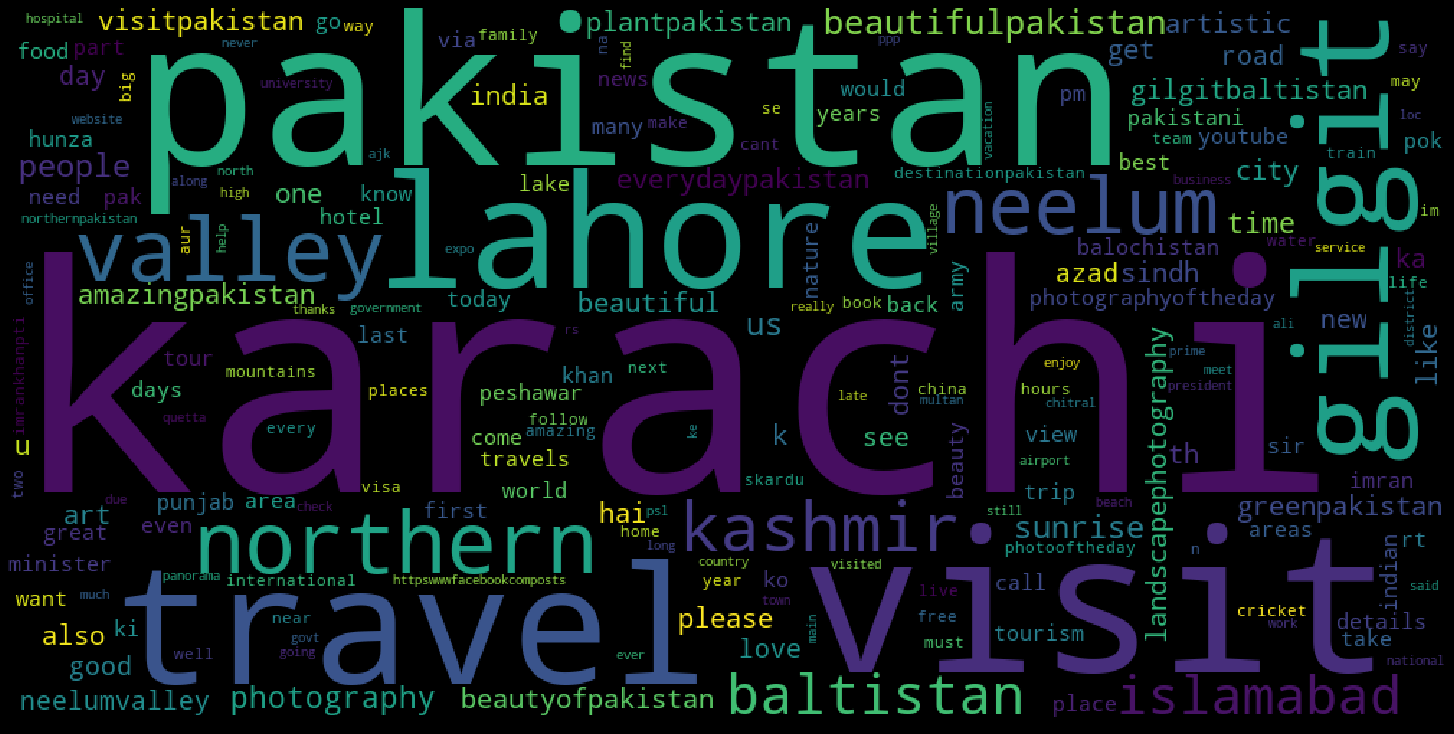

In [ ]:
tweet = ' '.join(df["text"])
#function to split text into word
tokens = word_tokenize(tweet)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)

wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(frequency_dist)
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Find Target Class for Tweets

In [ ]:
polarity_score = []

for text in df['text']:
    blob = TextBlob(text)
    for sentence in blob.sentences:
        if sentence.sentiment.polarity > 0.0:
            polarity_score.append('positive')
        elif sentence.sentiment.polarity < 0.0:
            polarity_score.append('negative')
        else:
            polarity_score.append('neutral')

df['target'] = pd.DataFrame(polarity_score)
df.head()

,text,city,target
0,photo captured beach karachi pakistan called s...,karachi,neutral
1,careem uber prices go due gas petrol price hik...,karachi,negative
2,australian volunteer found happiness teaching ...,karachi,positive
3,best beaches according readers kiwicom httpsbu...,karachi,positive
4,great initiative shelovestech six women circle...,karachi,positive


## Classes Frequency Graph

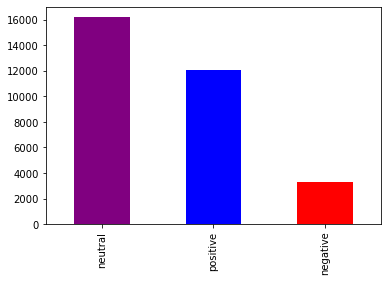

In [ ]:
df['target'].value_counts().plot.bar(color=['purple', 'blue', 'red'])

## Positive Tweets Word Cloud

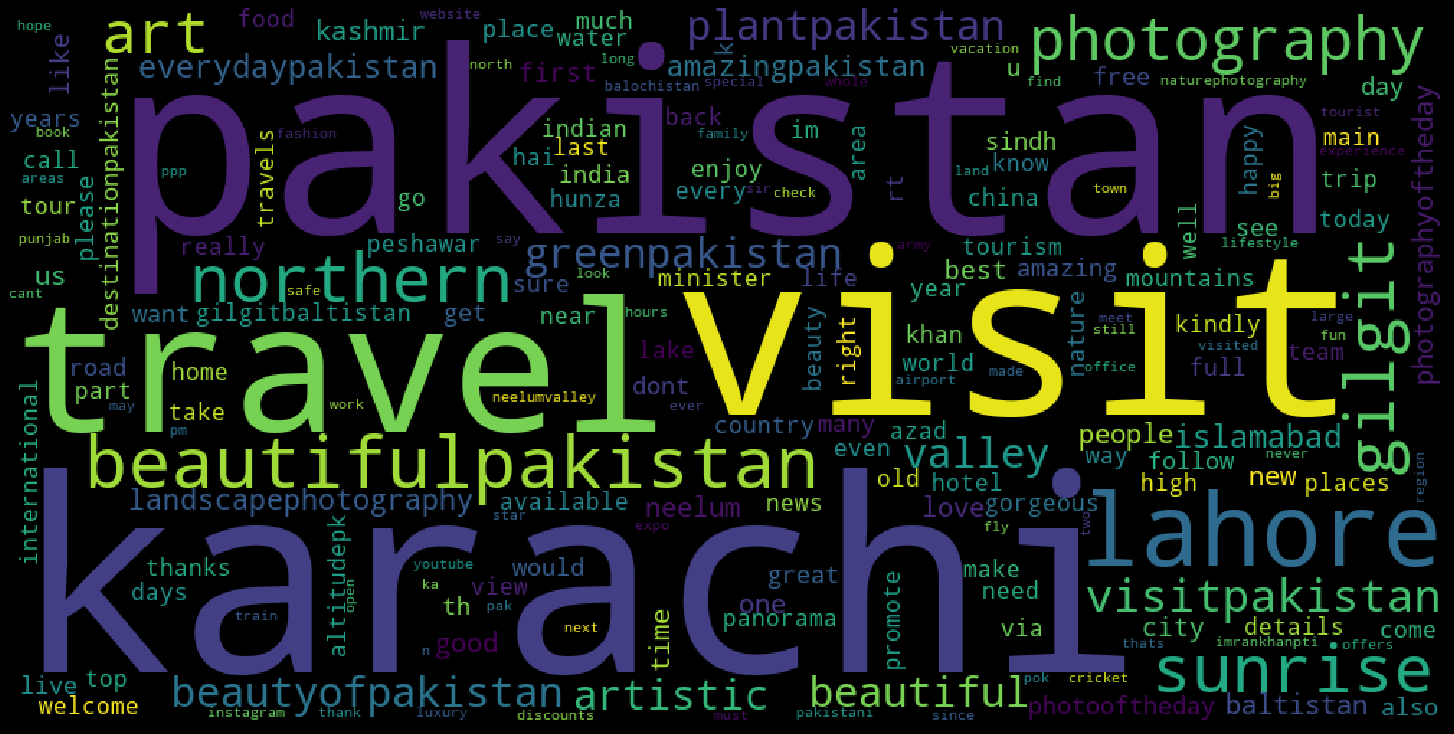

In [ ]:
tweet = ' '.join(df['text'][df['target'] == 'positive'] )
#function to split text into word
tokens = word_tokenize(tweet)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)

wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(frequency_dist)
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Negative Tweets Word Cloud

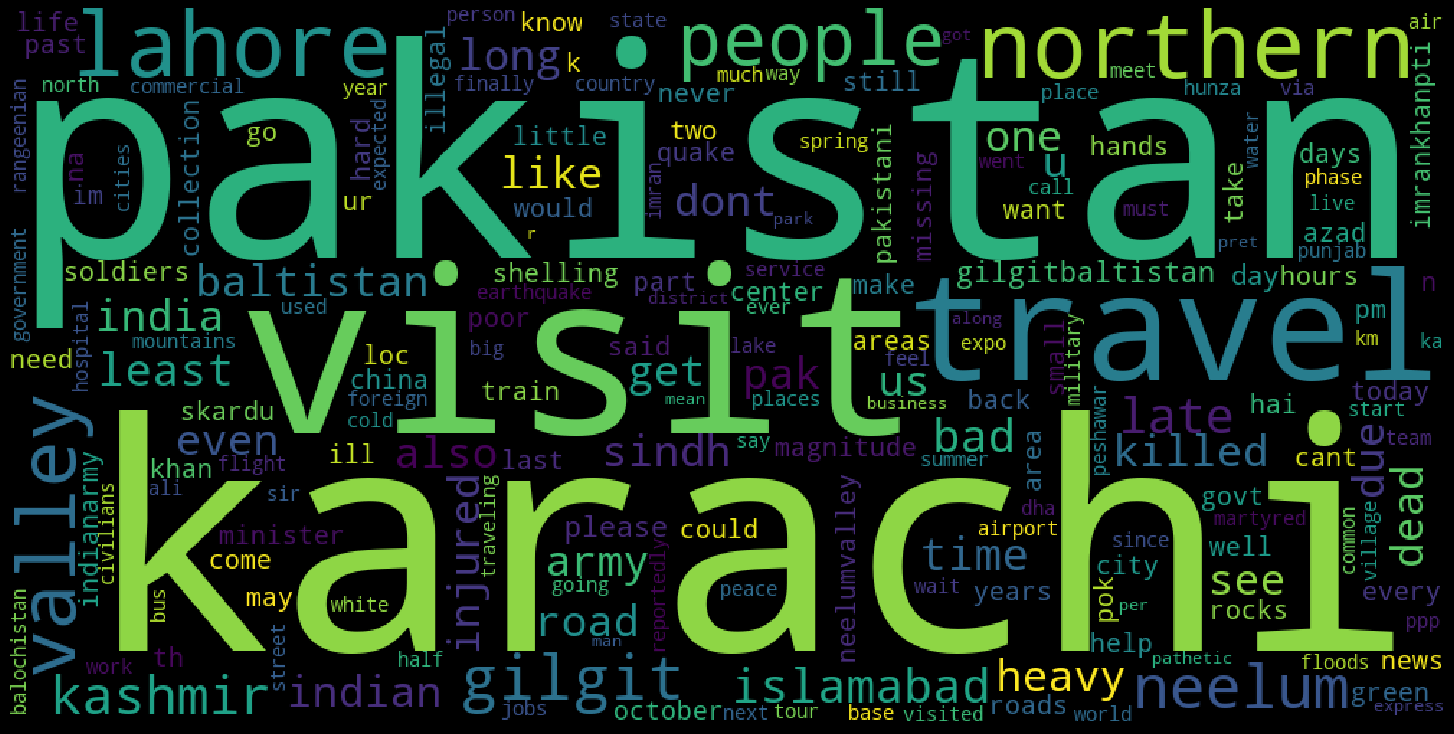

In [ ]:
tweet = ' '.join(df['text'][df['target'] == 'negative'] )
#function to split text into word
tokens = word_tokenize(tweet)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)

wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(frequency_dist)
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Class Labels Encoding

In [ ]:
label = LabelEncoder()
df_ = df.copy()
df_['target'] = label.fit_transform(df_['target'])
# dummies = pd.get_dummies(df.target)
# df = pd.concat([df, dummies], axis=1)
df_.head()

,text,city,target
0,photo captured beach karachi pakistan called s...,karachi,1
1,careem uber prices go due gas petrol price hik...,karachi,0
2,australian volunteer found happiness teaching ...,karachi,2
3,best beaches according readers kiwicom httpsbu...,karachi,2
4,great initiative shelovestech six women circle...,karachi,2


## Split the Data in train and test

In [ ]:
#Seperate data into feature and results
X, y = df_['text'], df_['target']

#Split data in train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## Uni-Gram TF-IDF Transormation

In [ ]:
my_categories=['0','1','2']
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 1))

# TF-IDF BASED FEATURE REPRESENTATION
tfidf.fit_transform(X_train)

train_feature_set=tfidf.transform(X_train)
test_feature_set=tfidf.transform(X_test)

## Logistic Regression

In [ ]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=0)

logreg.fit(train_feature_set,y_train)

#
y_pred=logreg.predict(test_feature_set)
lrm1 = accuracy_score(y_pred, y_test)

print('accuracy %s' % lrm1)
print(classification_report(y_test, y_pred,target_names=my_categories))
print('Confusion Matrix \n',confusion_matrix(y_test,y_pred))

accuracy 0.908066354311764
              precision    recall  f1-score   support

           0       0.93      0.58      0.71       842
           1       0.88      0.98      0.93      4040
           2       0.94      0.90      0.92      3015

    accuracy                           0.91      7897
   macro avg       0.92      0.82      0.85      7897
weighted avg       0.91      0.91      0.90      7897

Confusion Matrix 
 [[ 486  251  105]
 [   6 3966   68]
 [  28  268 2719]]


## Naive Bayes

In [ ]:
nb = MultinomialNB()

nb.fit(train_feature_set, y_train)

y_pred = nb.predict(test_feature_set)
nb1 = accuracy_score(y_pred, y_test)

print('accuracy %s' % nb1)
print(classification_report(y_test, y_pred,target_names=my_categories))
print('Confusion Matrix \n',confusion_matrix(y_test,y_pred))

accuracy 0.8209446625300747
              precision    recall  f1-score   support

           0       0.94      0.22      0.36       842
           1       0.85      0.90      0.87      4040
           2       0.78      0.88      0.83      3015

    accuracy                           0.82      7897
   macro avg       0.86      0.67      0.69      7897
weighted avg       0.83      0.82      0.80      7897

Confusion Matrix 
 [[ 187  304  351]
 [   4 3650  386]
 [   7  362 2646]]


## Random Forest Classifier

In [ ]:
rclf = RandomForestClassifier()
rclf.fit(train_feature_set,y_train)
y_pred = rclf.predict(test_feature_set)
print('accuracy %s' % accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred,target_names=my_categories))
print('Confusion Matrix \n',confusion_matrix(y_test,y_pred))

accuracy 0.9304799290869951
              precision    recall  f1-score   support

           0       0.96      0.68      0.79       842
           1       0.91      0.99      0.95      4040
           2       0.95      0.92      0.94      3015

    accuracy                           0.93      7897
   macro avg       0.94      0.86      0.89      7897
weighted avg       0.93      0.93      0.93      7897

Confusion Matrix 
 [[ 570  163  109]
 [   3 3995   42]
 [  23  209 2783]]


## Bi-Gram TF-IDF Transforamtion

In [ ]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))

# TF-IDF BASED FEATURE REPRESENTATION
tfidf.fit_transform(X_train)

train_feature_set=tfidf.transform(X_train)
test_feature_set=tfidf.transform(X_test)

## Logistic Regression

In [ ]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=0)

logreg.fit(train_feature_set,y_train)

#
y_pred=logreg.predict(test_feature_set)
lrm1 = accuracy_score(y_pred, y_test)

print('accuracy %s' % lrm1)
print(classification_report(y_test, y_pred,target_names=my_categories))
print('Confusion Matrix \n',confusion_matrix(y_test,y_pred))

accuracy 0.900721793085982
              precision    recall  f1-score   support

           0       0.92      0.54      0.68       842
           1       0.88      0.97      0.93      4040
           2       0.92      0.90      0.91      3015

    accuracy                           0.90      7897
   macro avg       0.91      0.81      0.84      7897
weighted avg       0.90      0.90      0.90      7897

Confusion Matrix 
 [[ 458  258  126]
 [  11 3931   98]
 [  27  264 2724]]


## Naive Bayes

In [ ]:
nb = MultinomialNB()

nb.fit(train_feature_set, y_train)

y_pred = nb.predict(test_feature_set)
nb1 = accuracy_score(y_pred, y_test)

print('accuracy %s' % nb1)
print(classification_report(y_test, y_pred,target_names=my_categories))
print('Confusion Matrix \n',confusion_matrix(y_test,y_pred))

accuracy 0.818665315942763
              precision    recall  f1-score   support

           0       0.95      0.21      0.34       842
           1       0.82      0.92      0.87      4040
           2       0.81      0.85      0.83      3015

    accuracy                           0.82      7897
   macro avg       0.86      0.66      0.68      7897
weighted avg       0.83      0.82      0.80      7897

Confusion Matrix 
 [[ 175  358  309]
 [   4 3731  305]
 [   6  450 2559]]


## Random Forest Classifier

In [ ]:
rclf = RandomForestClassifier()
rclf.fit(train_feature_set,y_train)
y_pred = rclf.predict(test_feature_set)
print('accuracy %s' % accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred,target_names=my_categories))
print('Confusion Matrix \n',confusion_matrix(y_test,y_pred))

accuracy 0.9203494998100544
              precision    recall  f1-score   support

           0       0.96      0.64      0.77       842
           1       0.90      0.99      0.94      4040
           2       0.95      0.91      0.93      3015

    accuracy                           0.92      7897
   macro avg       0.94      0.84      0.88      7897
weighted avg       0.92      0.92      0.92      7897

Confusion Matrix 
 [[ 536  191  115]
 [   2 3994   44]
 [  18  259 2738]]


In [ ]:
print('Proportion of the classes in the data:')
print(df.target.value_counts() / len(df))

Proportion of the classes in the data:
neutral     0.513692
positive    0.381549
negative    0.104758
Name: target, dtype: float64


## City wise percentage

In [ ]:
def city_wise(city):
    print(city, 'sentiemnt percentage pie chart')
    val = df[df['city'] == city]['target']
    (val.value_counts() / len(val)).plot.pie(autopct='%1.1f%%')

gilgit sentiemnt percentage pie chart


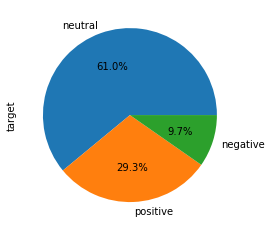

In [ ]:
city_wise('gilgit') # pass city name to function

## Finding Best City for Visiting

In [ ]:
cities = ['lahore', 'karachi', 'gilgit', 'northern area', 'neelum_valley']

percentage = []
for city in cities:
    val = df[df['city'] == city]['target']
    percentage.append({city : dict((val.value_counts() / len(val)))})

percentage

[{'lahore': {'positive': 0.5013485477178423,
   'neutral': 0.399792531120332,
   'negative': 0.09885892116182572}},
 {'karachi': {'neutral': 0.5136792452830189,
   'positive': 0.38384433962264153,
   'negative': 0.10247641509433962}},
 {'gilgit': {'neutral': 0.6099052880820837,
   'positive': 0.2932123125493291,
   'negative': 0.09688239936858721}},
 {'northern area': {'neutral': 0.4938948417642661,
   'positive': 0.3645651632195365,
   'negative': 0.14153999501619735}},
 {'neelum_valley': {'neutral': 0.6709986320109439,
   'positive': 0.23141814865481075,
   'negative': 0.09758321933424532}}]

In [ ]:
positive_tweet_percentage = []
for p in percentage:
    for city in p:
        positive_tweet_percentage.append((city,p[city]['positive']))

In [ ]:
cities =  pd.DataFrame(positive_tweet_percentage, columns =['city', 'percentage'])
cities = cities.sort_values('percentage', ascending=False)
cities = cities.set_index('city')
cities

,percentage
city,
lahore,0.501349
karachi,0.383844
northern area,0.364565
gilgit,0.293212
neelum_valley,0.231418


Text(0.5, 1.0, 'Best to worst city for visiting')

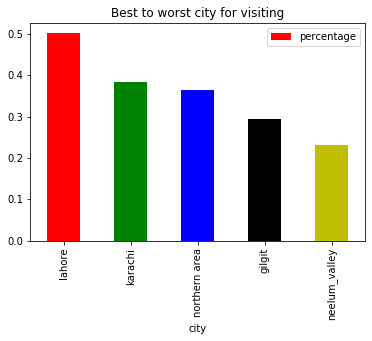

In [ ]:
cities.plot.bar(color = 'rgbkymc')
plt.title('Best to worst city for visiting')